In [3]:
%load_ext autoreload
# %load_ext memory_profiler
%autoreload 2
%matplotlib inline
from context import planvec

In [4]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage
from skimage import measure, segmentation

from planvec import img_proc
from planvec.common import PROJECT_ROOT_PATH

In [5]:
ASSETS_DIR      = os.path.join(PROJECT_ROOT_PATH, 'test', 'assets')
INPUT_IMAGE     = 'solid_lines.jpg'
OUTPUT_PDF_NAME = 'sample_output.pdf'

input_img = planvec.io.read_img(ASSETS_DIR, INPUT_IMAGE, to_bgr=True)
img = img_proc.copy_img(input_img)  # Perform processing on image copy to keep original input unaltered
#img = img_proc.add_gaussian_blur(img, 5, 5)
#img = img_proc.rectify_wrt_red_dots(img, (1200, 700))

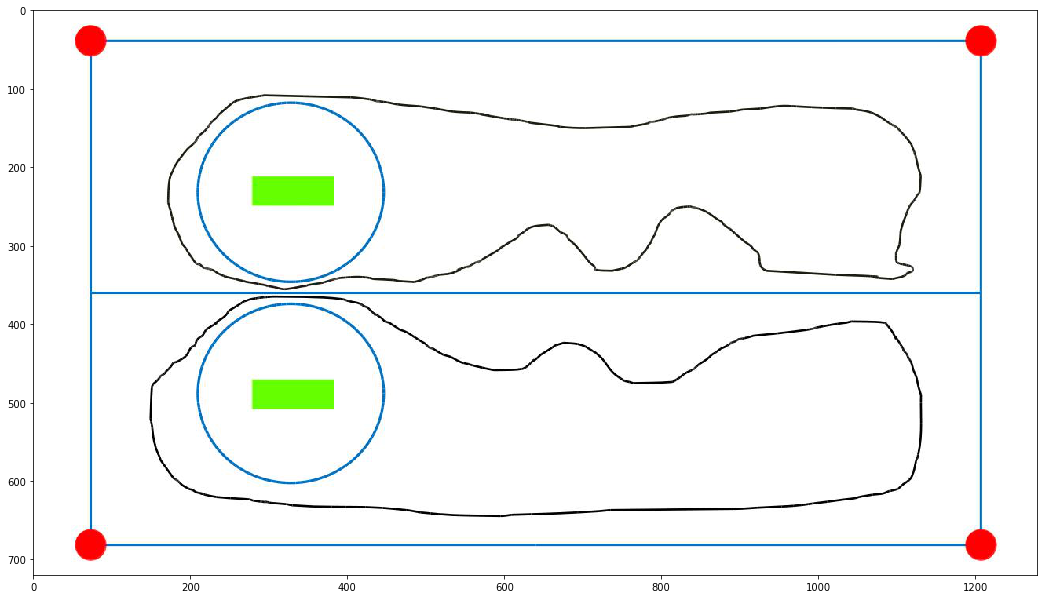

In [6]:
# Input image
planvec.vizualization.imshow(input_img, axis='on', figsize=(18,12), img_space='BGR')

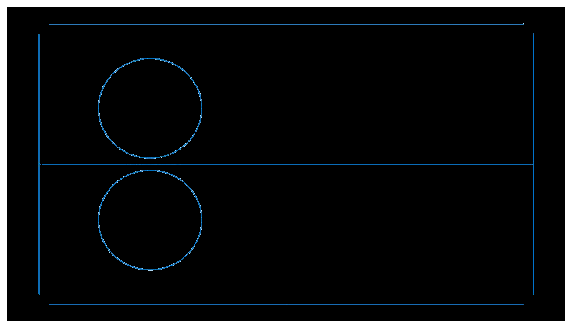

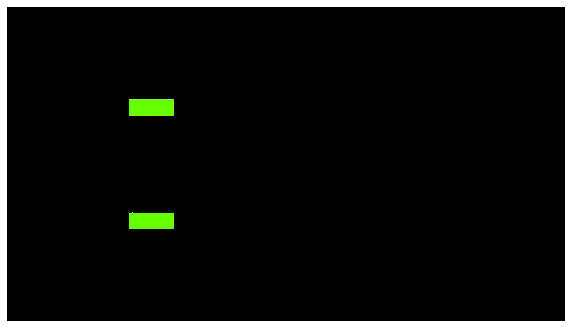

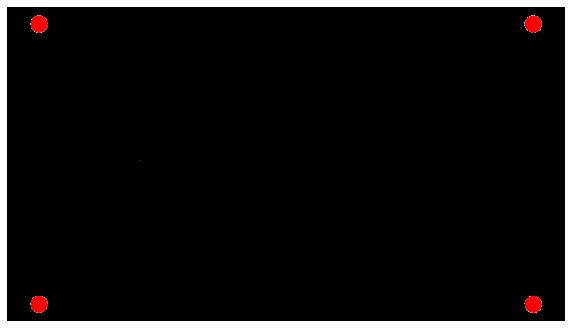

In [69]:
#planvec.vizualization.imshow(img, axis='on', figsize=(10, 10), img_space='BGR')

from planvec import color_range

img_blue = img_proc.filter_keep_by_hsv_range(input_img, color_range.BLUE)
planvec.vizualization.imshow(img_blue, axis='off', figsize=(10,10), img_space='BGR')

img_green = img_proc.filter_keep_by_hsv_range(input_img, color_range.GREEN)
planvec.vizualization.imshow(img_green, axis='off', figsize=(10,10), img_space='BGR')

img_red = img_proc.filter_keep_multi_ranges(input_img, [color_range.RED_LOW, color_range.RED_HIGH])
planvec.vizualization.imshow(img_red, axis='off', figsize=(10,10), img_space='BGR')
    
#img_clean = img_proc.filter_out_multi_ranges(input_img, [[50,59,0], [0,71,71], [170, 60, 60], [82,40,40]], [[70,255,255], [5,255,255], [180, 255, 255], [151,255,255]])
#planvec.vizualization.imshow(img_clean, axis='off', figsize=(10, 10), img_space='BGR')

In [6]:
"""
step 0 
    - filter out helper lines:
    - bounding box of the whole thing
    - circle around connection points
    - middle line
    
step 1 - filter for red edges and get 4 coordinates
    - HSV color filter

step 2 - warp image such that edge points are new edges
    - cv perspective transform
    - filter out points

step 3 - do all the processing to find contours
    - ...

step 4 - put in connector holes in correct positions
    - place it by known position ratio w.r.t. edges
"""

'\nstep 0 \n    - filter out helper lines:\n    - bounding box of the whole thing\n    - circle around connection points\n    - middle line\n    \nstep 1 - filter for red edges and get 4 coordinates\n    - HSV color filter\n\nstep 2 - warp image such that edge points are new edges\n    - cv perspective transform\n    - filter out points\n\nstep 3 - do all the processing to find contours\n    - ...\n\nstep 4 - put in connector holes in correct positions\n    - place it by known position ratio w.r.t. edges\n'

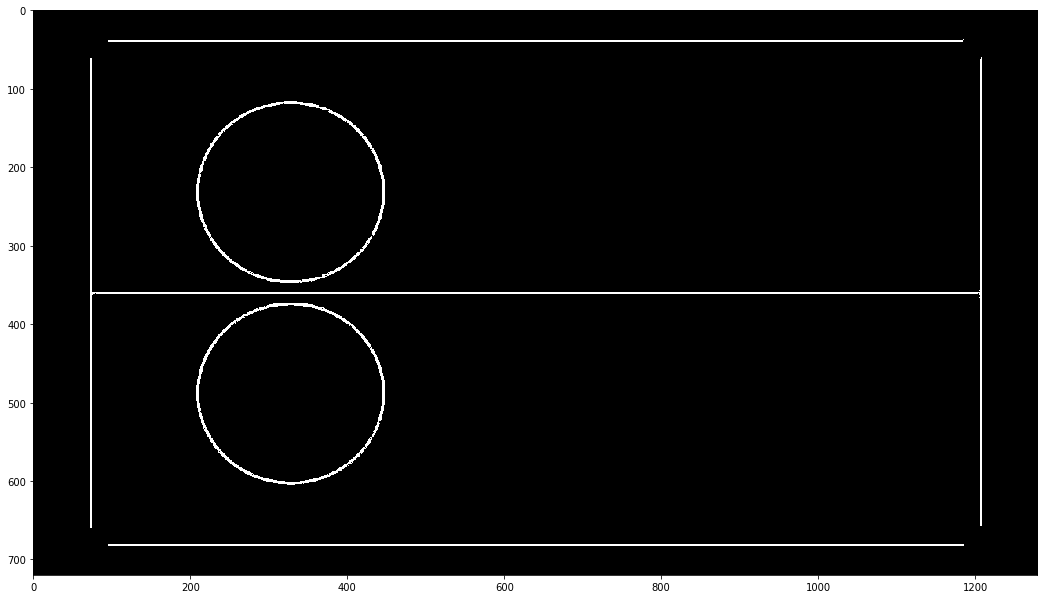

In [70]:
mask = img_proc.create_hsv_range_mask(img_proc.copy_img(input_img), color_range.BLUE)
planvec.vizualization.imshow(mask, axis='on', img_space='BGR', figsize=(18, 12))

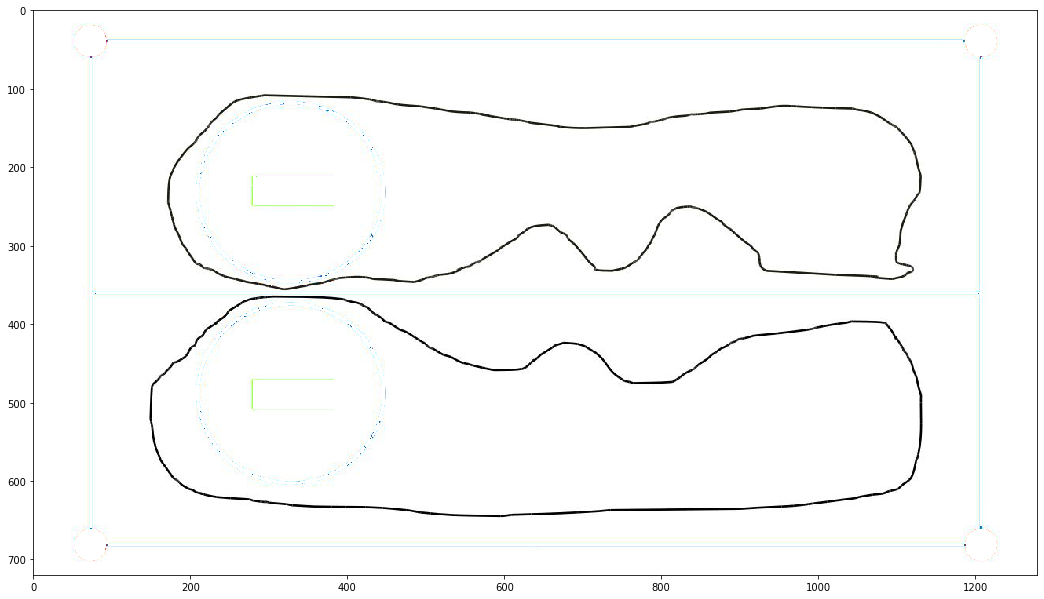

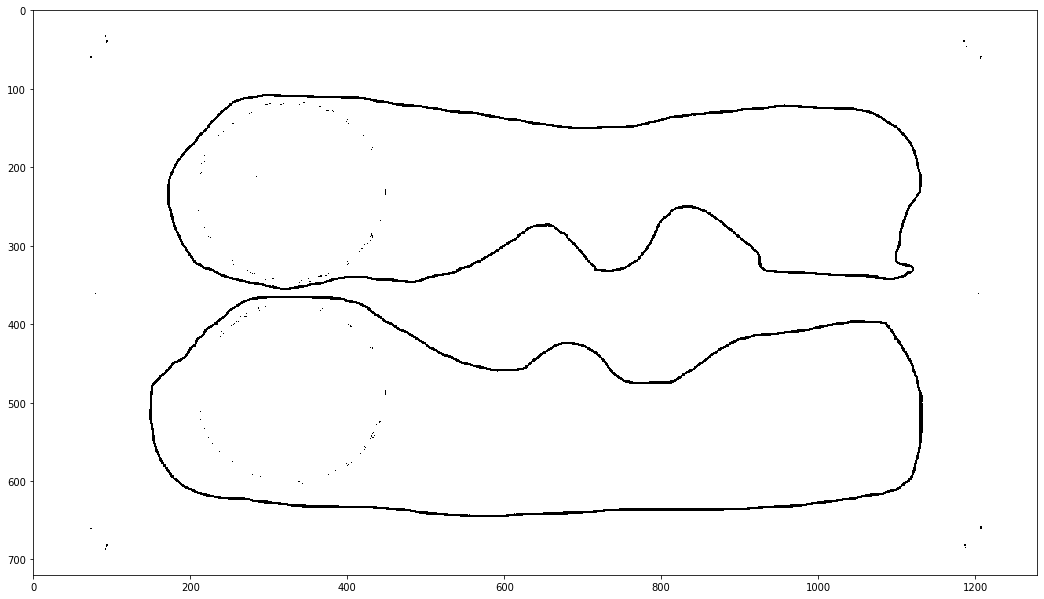

In [123]:
color_ranges = [color_range.BLUE, color_range.RED_HIGH, color_range.RED_LOW, color_range.GREEN]
img = planvec.img_proc.filter_multi_hsv_ranges_to_white(input_img, color_ranges)
planvec.vizualization.imshow(img, axis='on', img_space='BGR', figsize=(18, 12))
img = planvec.img_proc.img_to_greyscale(img)
img = img_proc.thresh_img(img, 200, 255)
planvec.vizualization.imshow(img, axis='on', img_space='BGR', figsize=(18, 12))

In [72]:
img_thresh = img_proc.thresh_img(img, thresh_val=201, max_val=255, thresh_type=cv2.THRESH_BINARY)

In [73]:
# Find and plots contours
#contours = img_proc.find_contours(img_thresh, 254)
#contours = img_proc.filter_contours_by_size(contours, n_points_thresh=1000)
#planvec.vizualization.plot_contours(contours, axis='on', figsize=(7, 10))

In [74]:
# Labelling connected regions
labelled_img, n = measure.label(img_thresh, background=0, return_num=True)
regions = measure.regionprops(labelled_img)

In [75]:
# Filtering regions
img_labelled_proc, filtered_regions = img_proc.filter_regions(labelled_img, regionprops=regions, area_threshold=50000)

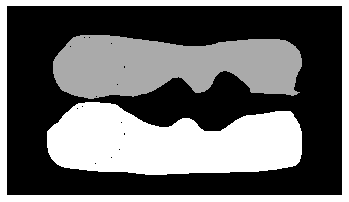

In [76]:
planvec.vizualization.imshow(img_labelled_proc)

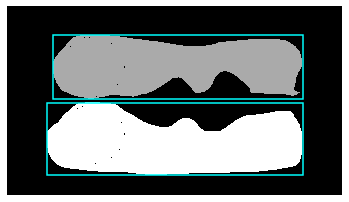

In [77]:
planvec.vizualization.plot_image_regions(img_labelled_proc, filtered_regions)

Contours left: 2


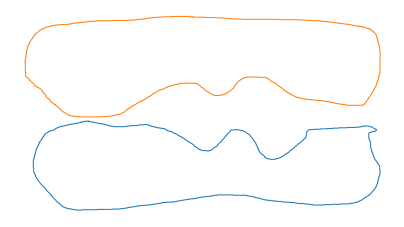

In [78]:
# Find contours of processed labelled image
contours = img_proc.find_contours(img_labelled_proc!=0, 0)
contours = img_proc.filter_contours_by_size(contours, n_points_thresh=100)
planvec.vizualization.plot_contours(contours, axis='off', figsize=(7, 10))
print(f'Contours left: {len(contours)}')

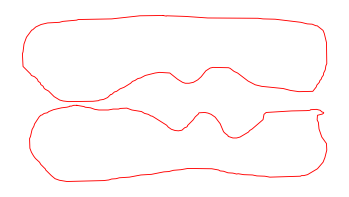

In [79]:
# Smooth contours by polygon approximation
approx_contours = []
for contour in contours:
    approx_contours.append(skimage.measure.approximate_polygon(contour.copy(), tolerance=1))
output_fig = planvec.vizualization.plot_contours(approx_contours, axis='off', color='red', linewidth=0.9)

In [18]:
output_fig.savefig('output_lw005.pdf')

In [19]:
# Stores the processed image to a PDF in the assets directory
# Deprecated
# img_proc.img_to_pdf(os.path.join(ASSETS_DIR, OUTPUT_PDF_NAME), img_thresh)

In [42]:
img_proc.live_color_filter(use_camera=False, img=img_proc.copy_img(input_img))

(hMin = 0 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 1 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 6 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 12 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 17 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 23 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 28 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 32 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 34 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 36 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 38 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 39 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 42 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 44 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 

(hMin = 43 , sMin = 31, vMin = 35), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 31, vMin = 37), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 31, vMin = 37), (hMax = 177 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 31, vMin = 37), (hMax = 171 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 31, vMin = 37), (hMax = 163 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 31, vMin = 37), (hMax = 149 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 31, vMin = 37), (hMax = 137 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 31, vMin = 37), (hMax = 122 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 31, vMin = 37), (hMax = 112 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 31, vMin = 37), (hMax = 102 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 31, vMin = 37), (hMax = 96 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 31, vMin = 37), (hMax = 91 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 31, vMin = 37), (hMax = 87 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 31, vMin = 37), (hMax

(hMin = 43 , sMin = 181, vMin = 37), (hMax = 57 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 184, vMin = 37), (hMax = 57 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 187, vMin = 37), (hMax = 57 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 189, vMin = 37), (hMax = 57 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 190, vMin = 37), (hMax = 57 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 199, vMin = 37), (hMax = 57 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 215, vMin = 37), (hMax = 57 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 219, vMin = 37), (hMax = 57 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 222, vMin = 37), (hMax = 57 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 220, vMin = 37), (hMax = 57 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 207, vMin = 37), (hMax = 57 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 191, vMin = 37), (hMax = 57 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 175, vMin = 37), (hMax = 57 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 168, vMin = 37), (

(hMin = 43 , sMin = 176, vMin = 37), (hMax = 76 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 176, vMin = 37), (hMax = 75 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 176, vMin = 37), (hMax = 74 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 176, vMin = 37), (hMax = 73 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 176, vMin = 37), (hMax = 72 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 176, vMin = 37), (hMax = 71 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 176, vMin = 37), (hMax = 70 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 176, vMin = 37), (hMax = 69 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 176, vMin = 37), (hMax = 68 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 176, vMin = 37), (hMax = 67 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 176, vMin = 37), (hMax = 66 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 176, vMin = 37), (hMax = 65 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 176, vMin = 37), (hMax = 64 , sMax = 255, vMax = 255)
(hMin = 43 , sMin = 176, vMin = 37), (

Input image shape: (720, 1280, 3)


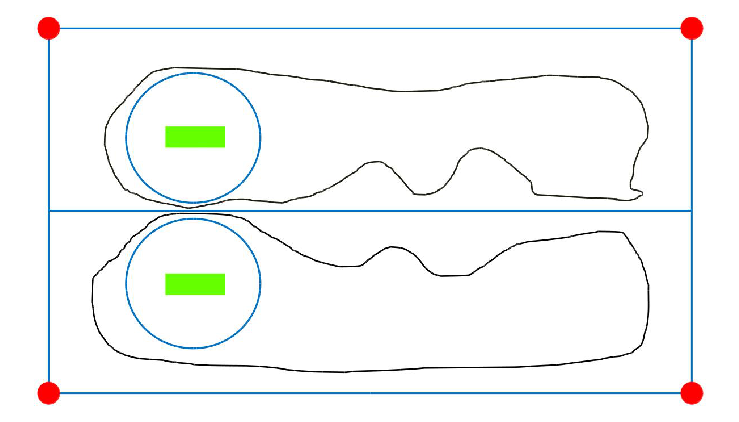

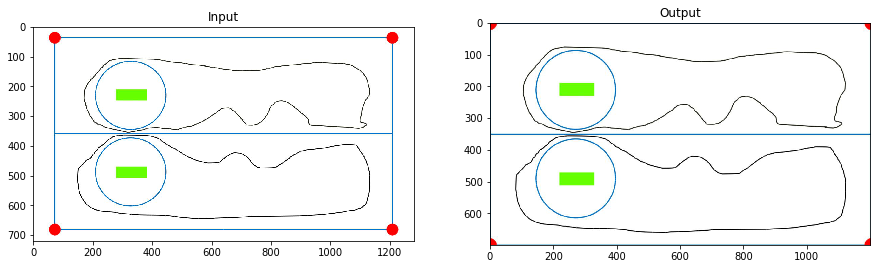

-----
Warping image wrt corners. Found 4 corners at positions
[[  72.86   38.74]
 [  72.99  681.22]
 [1206.93   38.72]
 [1207.03  681.25]]
Mapped to 
[[   0    0]
 [   0  700]
 [1200    0]
 [1200  700]].
New image size: (1200, 700).
Found 4 regions.
Region 1 has area: 387448 == (image size). Removed.
Region 4 has area: 1 < 40000. Too small. Removed.
After filtering, 2 are left.


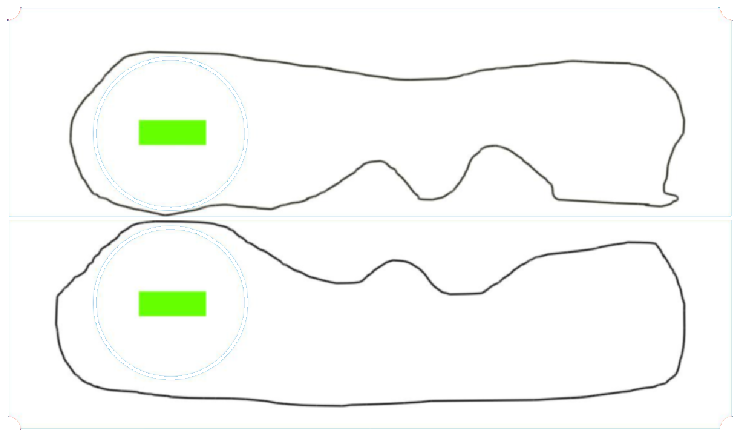

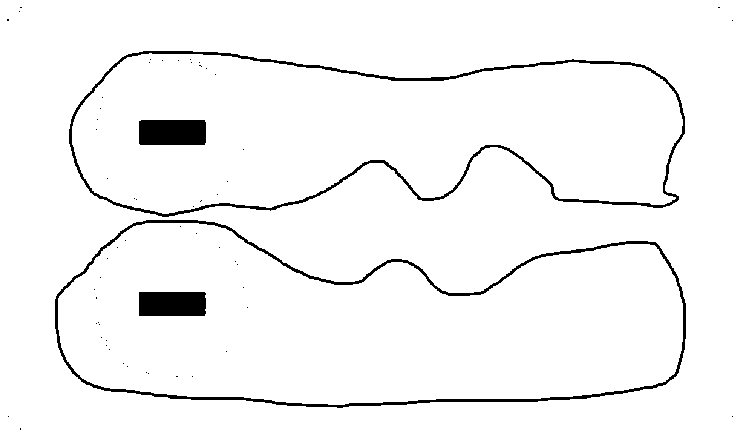

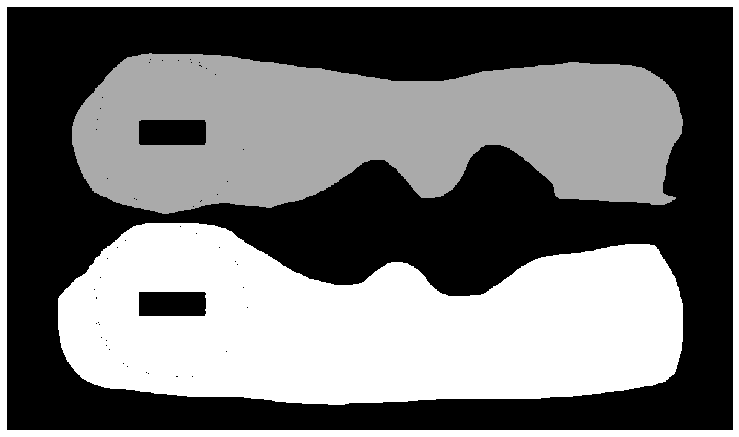

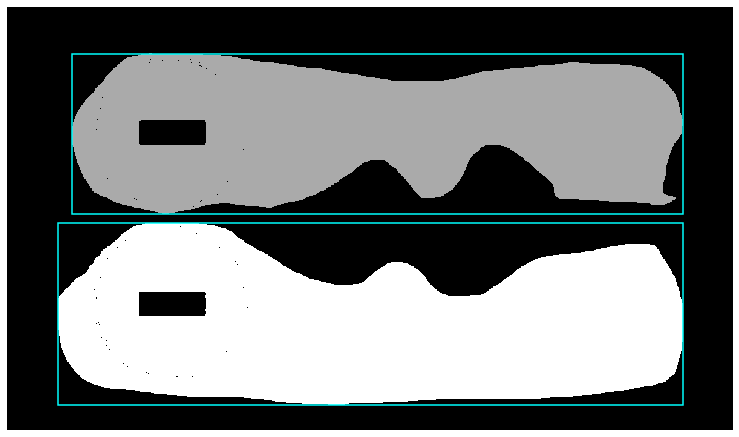

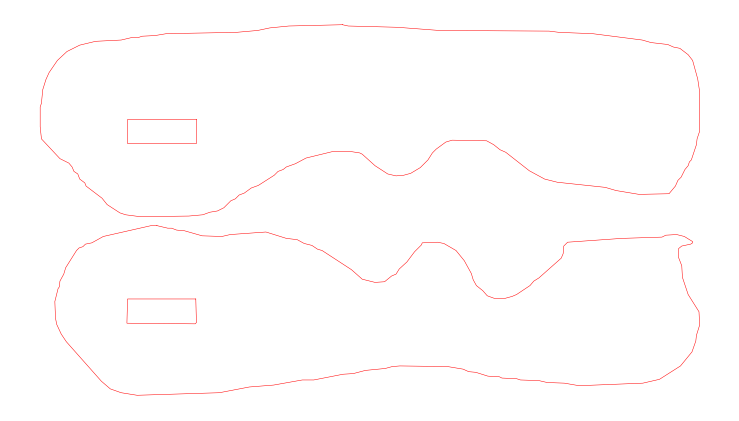

In [121]:
from planvec.pipeline import run_pipeline

output_img = run_pipeline(img_proc.copy_img(input_img), visualize_steps=True, verbose=True)

In [ ]:
output_img.savefig('output.pdf')